In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.cm as cm
import random
from my_functions import get_img_array, get_run_logdir, get_model_dir, make_gradcam_heatmap

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob


Comparando abordagem atual do post com hatmap construído sem resize da imagem

In [3]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

In [3]:
data_dir = 'PetImages'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


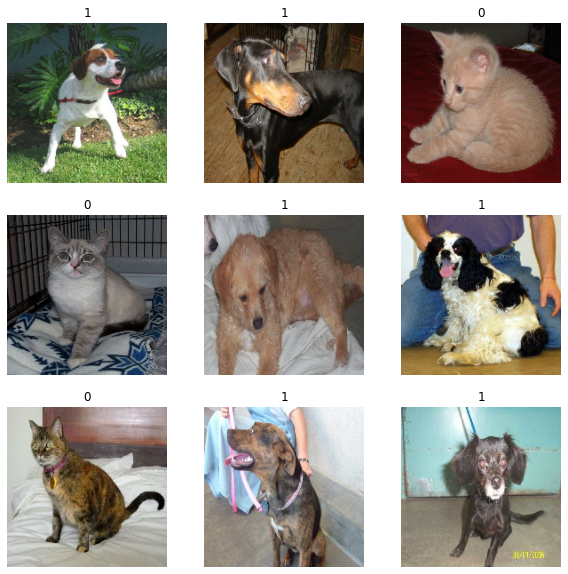

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
inputs = keras.Input(shape=(img_height, img_width, 3))

# data_augmentation = keras.Sequential(
#    [
#        layers.RandomFlip("horizontal"), 
#        layers.RandomRotation(0.1)
#    ]
# )
# x = data_augmentation(inputs)  # Apply random data augmentation
# # Pre-trained Xception weights requires that input be scaled
# # from (0, 255) to a range of (-1., +1.), the rescaling layer
# # outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    input_tensor=x
)
conv_7b_ac = base_model.get_layer('conv_7b_ac')
x = tf.keras.layers.GlobalAveragePooling2D()(conv_7b_ac.output)
# x = keras.layers.MaxPooling2D(pool_size=2)(x)
# x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x) 
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
______________________________________________________________________________________________

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# epochs = 100
# model.fit(
#     train_ds, 
#     epochs=epochs,
#     batch_size=32,
#     validation_data=val_ds,
#     callbacks=[tensorboard_cb, early_stopping_cb])
epochs = 1
base_model.trainable = False
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

586/586 [==============================] - 107s 158ms/step - loss: 0.0695 - accuracy: 0.9783 - val_loss: 0.0502 - val_accuracy: 0.9840


In [9]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

epochs = 1

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[tensorboard_cb, early_stopping_cb])

run_modeldir = get_model_dir()
model.save(run_modeldir)

586/586 [==============================] - 299s 476ms/step - loss: 0.1390 - accuracy: 0.9471 - val_loss: 0.1270 - val_accuracy: 0.9712
INFO:tensorflow:Assets written to: .\my_models\run_2021_10_30-21_34_34\assets


In [10]:
def find_target_layer(model):
   # attempt to find the final convolutional layer in the network
   # by looping over the layers of the network in reverse order
   for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
         return layer.name
   # otherwise, we could not find a 4D layer so the GradCAM
   # algorithm cannot be applied
   raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

In [11]:
find_target_layer(model)

'conv_7b_ac'

In [14]:
last_conv_layer_name = "conv_7b_ac"
img_size = image_size

In [15]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

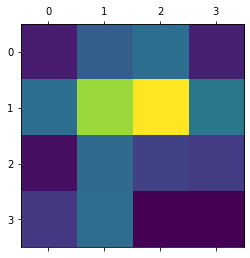

In [18]:
preprocess_input = keras.applications.xception.preprocess_input
img_path = "PetImages\\Cat\\3.jpg"
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

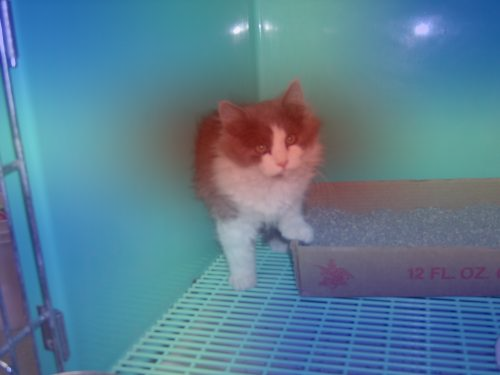

In [80]:
def build_gradcam(img_path, heatmap, alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # jet = cm.get_cmap("jet")
    jet = cm.get_cmap("bwr")
    # jet = cm.get_cmap("OrRd")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # # Save the superimposed image
    # superimposed_img.save(cam_path)

    # # Display Grad CAM
    # display(Image(cam_path))

    # Return image
    return superimposed_img



preprocess_input = keras.applications.xception.preprocess_input
img_path = "PetImages\\Cat\\1157.jpg"
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
build_gradcam(img_path, heatmap)

In [51]:
def find_target_layer(model):
   # attempt to find the final convolutional layer in the network
   # by looping over the layers of the network in reverse order
   for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
         return layer.name
   # otherwise, we could not find a 4D layer so the GradCAM
   # algorithm cannot be applied
   raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

In [81]:
def superimpose_gradcam(img_path, image_size, current_model):
   preprocess_input = keras.applications.xception.preprocess_input
   # img_path = "PetImages\\Cat\\1157.jpg"
   # Prepare image
   img_array = preprocess_input(get_img_array(img_path, size=image_size))

   # Remove last layer's softmax
   current_model.layers[-1].activation = None

   # Generate class activation heatmap
   last_conv_layer_name = find_target_layer(current_model)
   heatmap = make_gradcam_heatmap(img_array, current_model, last_conv_layer_name)
   return build_gradcam(img_path, heatmap)

In [95]:
def test_grad_cam_in_path(default_images_path):
   plt.figure(figsize=(10, 10))
   list_images = glob.glob(default_images_path + "*")
   for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img_path = random.choice(list_images)
      superimposed_img = superimpose_gradcam( 
                        current_model=model, 
                        img_path=img_path,
                        image_size=image_size,
                        original_image_color_mode=original_image_color_mode)
      plt.imshow(superimposed_img)
      plt.title('{}'.format(img_path))
      plt.axis("off")

In [11]:
# model = keras.models.load_model("my_models\\run_2021_10_30-21_34_34")
model = keras.models.load_model("my_models\\run_2021_10_31-18_37_00")

In [6]:
def check_dataset(dataset):
   plt.figure(figsize=(10, 10))
   for images, labels in dataset.take(1):
      for i in range(9):
         ax = plt.subplot(3, 3, i + 1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title('...' + train_ds.file_paths[i][-20:])
         plt.axis("off")

root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

root_modeldir = os.path.join(os.curdir, "my_models")
def get_model_dir():
   import time
   run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
   return os.path.join(root_modeldir, run_id)

def find_target_layer(model):
   # attempt to find the final convolutional layer in the network
   # by looping over the layers of the network in reverse order
   for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
         return layer.name
   # otherwise, we could not find a 4D layer so the GradCAM
   # algorithm cannot be applied
   raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array
   
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def build_gradcam(img_path, heatmap, color_map, alpha=0.5):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path, color_mode="grayscale")
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # jet = cm.get_cmap("jet")
    jet = cm.get_cmap(color_map)
    # jet = cm.get_cmap("OrRd")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # # Save the superimposed image
    # superimposed_img.save(cam_path)

    # # Display Grad CAM
    # display(Image(cam_path))

    # Return image
    return superimposed_img

def superimpose_gradcam(img_path, image_size, current_model, grad_colormap):
   preprocess_input = keras.applications.xception.preprocess_input
   # img_path = "PetImages\\Cat\\1157.jpg"
   # Prepare image
   img_array = preprocess_input(get_img_array(img_path, size=image_size))

   # Remove last layer's softmax
   current_model.layers[-1].activation = None

   # Generate class activation heatmap
   last_conv_layer_name = find_target_layer(current_model)
   heatmap = make_gradcam_heatmap(img_array, current_model, last_conv_layer_name)
   return build_gradcam(img_path, heatmap, color_map=grad_colormap)

def test_grad_cam_in_path(current_model, default_images_path, image_size, grad_colormap):
   plt.figure(figsize=(10, 10))
   list_images = glob.glob(default_images_path + "*")
   for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img_path = random.choice(list_images)
      superimposed_img = superimpose_gradcam( 
                        current_model=current_model, 
                        img_path=img_path,
                        image_size=image_size,
                        grad_colormap=grad_colormap)
      plt.imshow(superimposed_img)
      plt.title('{}'.format(img_path[-15:]))
      plt.axis("off")

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 89, 89, 32)   864         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 89, 89, 32)   96          conv2d[0][0]                     
______________________________________________________________________________________________

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (3,)

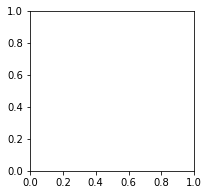

In [12]:
test_grad_cam_in_path(
      model, 
      "datasetsSARS-COV-2 Ct-Scan\\COVID-positive\\", 
      image_size, 
      grad_colormap="coolwarm")

NameError: name 'plt' is not defined